<a href="https://colab.research.google.com/github/Vermillion-1/Colab-Projects/blob/main/Plant_Disease_Detection_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#To Do:

* fix the folder names in Google Drive:

    Apple(1)/Train -> Apple/Train and so on

* add explainatory comments for yourself and others
* fix and share Google drive with other so that they can run the code on their end as well

#Code

In [ ]:
import os
import numpy as np
from PIL import Image
from google.colab import drive

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# New section

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
drive.mount('/content/drive', force_remount = True)


Mounted at /content/drive


# Convert Images to np arrays and create labels

In [ ]:
# Set the paths to the train, test, and validation directories
train_dir = '/content/drive/MyDrive/archive/Apple (1)/Train'
test_dir = '/content/drive/MyDrive/archive/Apple (1)/Test'
val_dir = '/content/drive/MyDrive/archive/Apple (1)/Val'



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(os.listdir(train_dir))

['Black Rot', 'Cedar Apple Rust', 'Apple Scab', 'Healthy']


In [ ]:
for folderName in os.listdir(train_dir):
    print(folderName + '\n')
    # for fileName in os.listdir(train_dir + '/' + folderName):
        # print(fileName)

Black Rot

Cedar Apple Rust

Apple Scab

Healthy



In [ ]:
def img_to_array(dir):
    images = []
    labels = []

    for folderName in os.listdir(dir):
        folder_dir = os.path.join(dir, folderName)
        if os.path.isdir(folder_dir):
            for fileName in os.listdir(folder_dir):
                if fileName.endswith('.JPG'):
                    img = Image.open(os.path.join(folder_dir, fileName))
                    resized_img = img.resize((128, 128))
                    img_arr = np.array(resized_img)
                    images.append(img_arr)
                    labels.append(folderName)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels




In [ ]:
# Read and store images from the train directory
train_images, train_labels = img_to_array(train_dir)

# Read and store images from the test directory
test_images, test_labels = img_to_array(test_dir)

# Read and store images from the validation directory
val_images, val_labels = img_to_array(val_dir)

(7771, 128, 128, 3) (7771,)
(196, 128, 128, 3) (196,)
(1747, 128, 128, 3) (1747,)


Finished, Reading the images and converting them into np.arrays,
the visualized images prove that it has been done properly

Next Task ->

> * explore and select which pre processing techiniques to apply

> * Normalize -> no, not sure as of now

> * Filters -> don't understand the need yet...

> * Binary Segmentataion -> can use Otsu's Thresholding, check with and without (a few authors used this)

> * rotation -> yes, relevant with respect to data given

> * brightness -> no for now, can reconsider

> * tokenize the labels -> even one-hot-encoding is fine, we have only 4 class of diseases here so 4 bits per label,

> * 10,000 images * 4 bits per labels -> good enough + simple





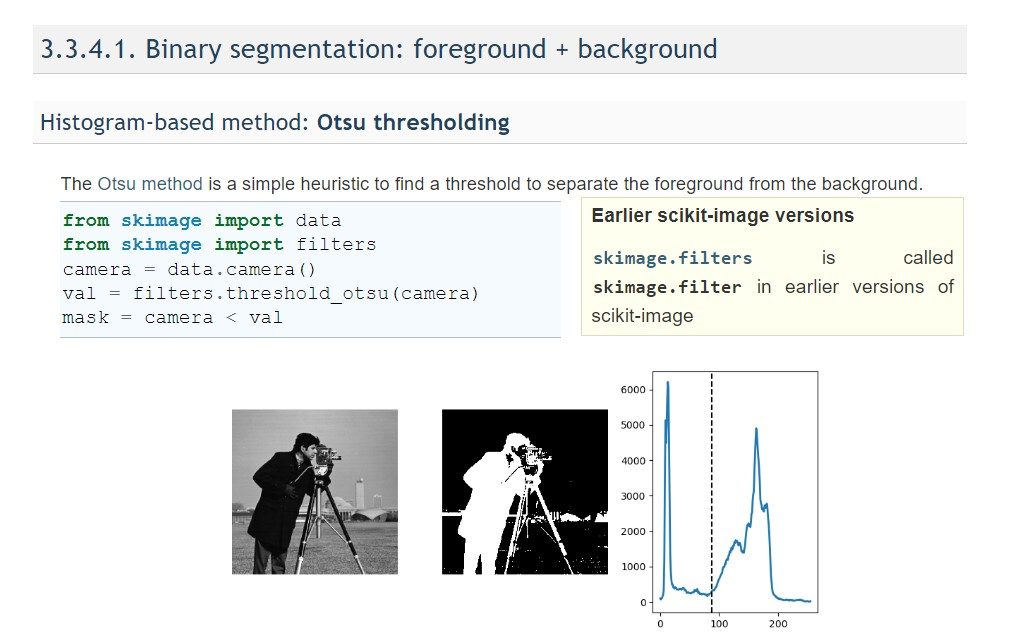

# Encode Labels

In [ ]:
print(train_labels)

['Black Rot' 'Black Rot' 'Black Rot' ... 'Healthy' 'Healthy' 'Healthy']


In [ ]:
# Normalize pixel values to the range of 0-1
train_images = train_images.astype('float32') / 255.0
val_images = val_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [ ]:
# # Save train_images
# np.save('train_images.npy', train_images)

# # Save val_images
# np.save('val_images.npy', val_images)

# # Save test_images
# np.save('test_images.npy', test_images)


In [ ]:
# Create an instance of OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the labels
train_labels = encoder.fit_transform([[label] for label in train_labels]).toarray()
test_labels = encoder.fit_transform([[label] for label in test_labels]).toarray()
val_labels = encoder.fit_transform([[label] for label in val_labels]).toarray()

In [ ]:
print(train_labels)

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


# Train Model

In [ ]:
# Define the number of classes
num_classes = 4

# Create a CNN model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=2)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Train the model with callbacks
history = model.fit(train_images, train_labels, epochs=20, batch_size=32,
                    validation_data=(val_images, val_labels),
                    callbacks=[early_stopping, reduce_lr, model_checkpoint])

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

# Retrieve training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Convert training history to lists
training_loss_list = list(training_loss)
validation_loss_list = list(validation_loss)
training_accuracy_list = list(training_accuracy)
validation_accuracy_list = list(validation_accuracy)



Epoch 1/20
243/243 [==============================] - 17s 24ms/step - loss: 0.5392 - accuracy: 0.7890 - val_loss: 0.2782 - val_accuracy: 0.8952 - lr: 0.0010
Epoch 2/20
243/243 [==============================] - 5s 21ms/step - loss: 0.2306 - accuracy: 0.9173 - val_loss: 0.1864 - val_accuracy: 0.9307 - lr: 0.0010
Epoch 3/20
243/243 [==============================] - 4s 18ms/step - loss: 0.1550 - accuracy: 0.9454 - val_loss: 0.2488 - val_accuracy: 0.9187 - lr: 0.0010
Epoch 4/20
243/243 [==============================] - 5s 19ms/step - loss: 0.1320 - accuracy: 0.9530 - val_loss: 0.1457 - val_accuracy: 0.9462 - lr: 0.0010
Epoch 5/20
243/243 [==============================] - 5s 20ms/step - loss: 0.0785 - accuracy: 0.9726 - val_loss: 0.1722 - val_accuracy: 0.9445 - lr: 0.0010
Epoch 6/20
243/243 [==============================] - 5s 19ms/step - loss: 0.0549 - accuracy: 0.9811 - val_loss: 0.1333 - val_accuracy: 0.9468 - lr: 0.0010
Epoch 7/20
243/243 [==============================] - 4s 18ms/s

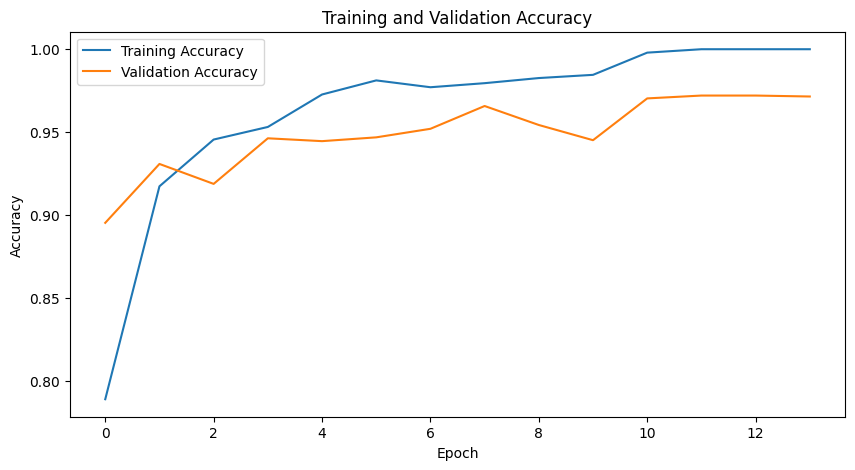

In [ ]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(training_accuracy_list, label='Training Accuracy')
plt.plot(validation_accuracy_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

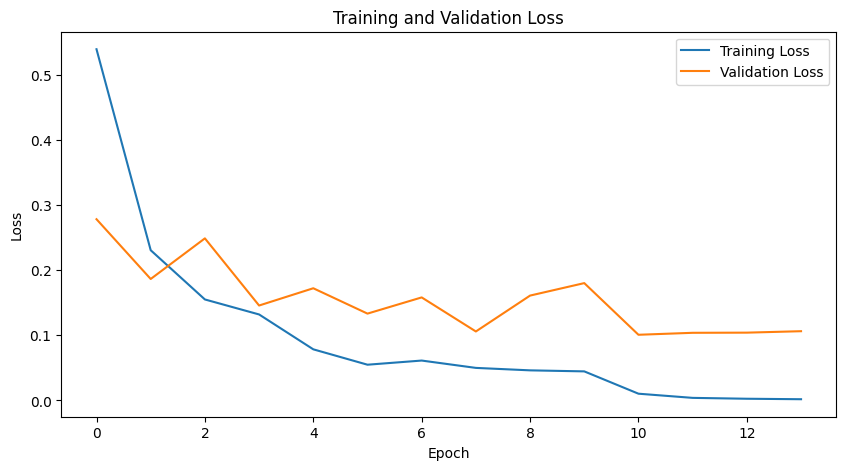

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(training_loss_list, label='Training Loss')
plt.plot(validation_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()